# Project Description

The Sweet Lift Taxi company has compiled historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for this prediction.

The recm metric in the test set should not exceed 48.

## Project instructions.

1. Download the data and do the rig for an hour.
2. Analyze the data
3. Train different models with different hyperparameters. The test sample must be 10% of the initial data set. 4. Try the data using the test sample and provide a conclusion.

## Data Description

The data is stored in the `taxi.csv` file. 	
The number of orders is in the `num_orders` column.

## import libraries

In [1]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.metrics
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import MaxAbsScaler
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score
from statsmodels.tsa.seasonal import seasonal_decompose

## Preparación

In [2]:
#import data
df = pd.read_csv('taxi.csv', index_col=[0],parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
#Sorts the DataFrame by its index in ascending order. 
df.sort_index(inplace=True)

In [4]:
# Resample the DataFrame by hour ('H') and sum the values within each hour
df =df.resample('H').sum()

/var/folders/zz/1lh114c55jj9tjb2vztk4z340000gq/T/ipykernel_4069/3472708785.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df =df.resample('H').sum()


In [5]:
#Analyze general information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [6]:
#generate descriptive statistics for the numerical columns in the DataFrame 
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [7]:
#Print the first 5 lines of the Dataframe
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

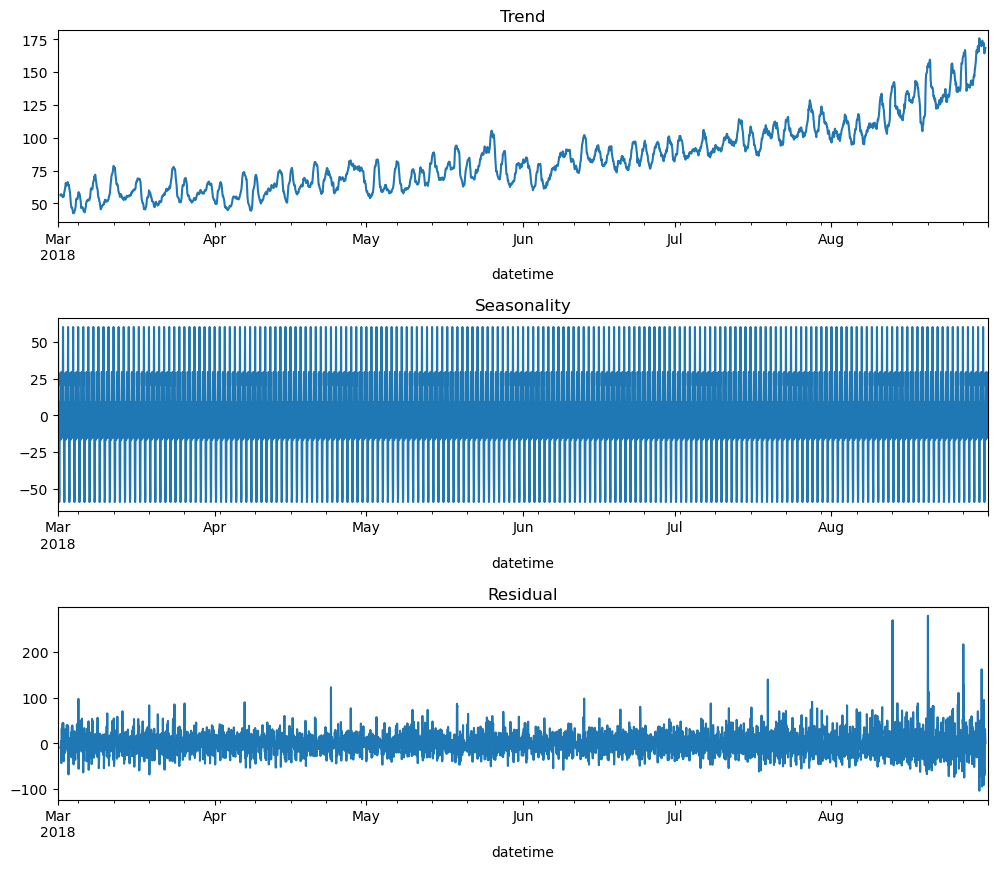

In [8]:
# Decompose the time series into trend, seasonality, and residual components
decomposed = seasonal_decompose(df) 

# Create a figure with specified size
plt.figure(figsize=(12,10))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Create the first subplot for the trend component
plt.subplot(311)  # 3 rows, 1 column, 1st subplot
decomposed.trend.plot(ax=plt.gca()) 
plt.title('Trend')

# Create the second subplot for the seasonality component
plt.subplot(312)  # 3 rows, 1 column, 2nd subplot
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# Create the third subplot for the residual component
plt.subplot(313)  # 3 rows, 1 column, 3rd subplot
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residual')

# Show the plot
plt.show()

##Training

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    """
    This function creates new features from an existing DataFrame.

    Args:
        data (pandas.DataFrame): The DataFrame containing the original data.
        max_lag (int): The maximum lag value to create lagged features for 'num_orders'.
        rolling_mean_size (int): The window size for calculating the rolling mean of 'num_orders'.

    Returns:
        pandas.DataFrame: The modified DataFrame with new features.
    """

    # Extract year, month, day, and day of week from the DataFrame index
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    # Create lagged features for 'num_orders'
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        # Shift 'num_orders' by 'lag' positions and assign to a new column

    # Create a rolling mean feature for 'num_orders'
    data['rolling_mean'] = (data['num_orders']).shift().rolling(rolling_mean_size).mean()
    # Shift 'num_orders' by 1 position, calculate rolling mean with window size 'rolling_mean_size', and assign to a new column

    return data

In [10]:
# Call the function to create new features for the DataFrame
make_features(df,24,3)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,207.000000
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,186.666667
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,165.666667


## Proof

In [11]:
#Treat empty values
df = df.fillna(0)

In [12]:
#Show the first rows of the modified Dataframe 
df.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018-03-01 01:00:00,85,2018,3,1,3,124.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.333333
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.000000


In [13]:
# Select the target variable 
target = df['num_orders'] 

# Select the features by dropping the target column
features = df.drop(['num_orders'], axis=1)

In [14]:
# Split data into training and testing sets
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.10, random_state=12345, shuffle=False
)

In [15]:
# Create a linear regression model
model = LinearRegression()

# Train the model on the training features and target
model.fit(train_features, train_target)

# Make predictions on the training features
predict_train1 = model.predict(train_features)

# Make predictions on the testing features
predict_test1 = model.predict(test_features)

# Print results for linear regression model
print('LinearRegression:')
print('RMSE (Root Mean Squared Error) for training set:',
      mean_squared_error(train_target, predict_train1))
print('RMSE (Root Mean Squared Error) for test set:',
      mean_squared_error(test_target, predict_test1))

LinearRegression:
RMSE (Root Mean Squared Error) for training set: 671.4774982135625
RMSE (Root Mean Squared Error) for test set: 2100.618191925766


In [16]:
# Define a parameter grid for the RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'random_state': [1234, 12345, 54321]  # Seed for random number generation
}

# Create a GridSearchCV object to perform grid search
grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=param_grid,
                           cv=5,  
                           scoring='neg_mean_squared_error')  # Minimize mean squared error

# Fit the grid search to the training data
grid_search.fit(train_features, train_target)

# Make predictions on the training data using the best model from grid search
predict_train2 = grid_search.predict(train_features)

# Make predictions on the test data using the best model from grid search
predict_test2 = grid_search.predict(test_features)

# Print results for RandomForestRegressor
print('RandomForestRegressor:')
print('n_estimators:', grid_search.best_params_['n_estimators'])  # Print best number of estimators
print('RECM para el conjunto de entrenamiento:', mean_squared_error(train_target, predict_train2))  # Print RMSE for training set
print('RECM para el conjunto de prueba:', mean_squared_error(test_target, predict_test2))  # Print RMSE for test set

# Access the results of the grid search
cv_results = grid_search.cv_results_

# Print the best parameters found by grid search
print("Mejores parámetros:", grid_search.best_params_)

# Print the best score (negative mean squared error in this case)
print("Mejor puntaje:", grid_search.best_score_)

RandomForestRegressor:
n_estimators: 300
RECM para el conjunto de entrenamiento: 74.37752993345636
RECM para el conjunto de prueba: 1873.0267859477121
Mejores parámetros: {'n_estimators': 300, 'random_state': 1234}
Mejor puntaje: -622.6447352192033


In [18]:
# Import XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=54321)

# Train the XGBoost model on training features and target
model.fit(train_features, train_target)

# Make predictions on training features
predict_train3 = model.predict(train_features)

# Make predictions on test features
predict_test3 = model.predict(test_features)

# Evaluate XGBRegressor performance
print('XGBRegressor:')
print('RMSE for training set:', mean_squared_error(train_target, predict_train3))
print('RMSE for test set:', mean_squared_error(test_target, predict_test3))

XGBRegressor:
RMSE for training set: 22.084192276000977
RMSE for test set: 2091.916748046875


In [20]:
# Define a parameter grid for CatBoostRegressor
param_grid = {
    'depth': [6, 8, 10],  # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate for gradient boosting
    'iterations': [500, 1000]  # Number of boosting iterations
}

# Create a GridSearchCV object to perform grid search with CatBoostRegressor
grid_search = GridSearchCV(estimator=CatBoostRegressor(verbose=0),
                           param_grid=param_grid,
                           cv=5,  # Use 5-fold cross-validation
                           scoring='neg_mean_squared_error')  # Minimize mean squared error

# Fit the grid search to the training data
grid_search.fit(train_features, train_target)

# Make predictions on the training data using the best model from grid search
predict_train4 = grid_search.predict(train_features)

# Make predictions on the test data using the best model from grid search
predict_test4 = grid_search.predict(test_features)

# Print results for CatBoostRegressor
print('CatBoost:')
print('RECM for training set:', mean_squared_error(train_target, predict_train4))
print('RECM for test set:', mean_squared_error(test_target, predict_test4))

# Print the best parameters found by grid search
print('Best parameters:')
print(grid_search.best_params_)

# Print the best score (negative mean squared error in this case)
print('Best score (negative mean squared error):')
print(grid_search.best_score_)

CatBoost:
RECM for training set: 127.36956177595341
RECM for test set: 1723.5177967001234
Best parameters:
{'depth': 6, 'iterations': 500, 'learning_rate': 0.1}
Best score (negative mean squared error):
-577.2441784884768


## Conclusion

After the initial analysis of the data, different models were trained with the objective of finding the best model, in terms of EAM, for predicting car prices, obtaining the following:

From the results obtained in the implementation of the linear regression, random forest, XGBoost and CatBoost models to predict the demand for taxis, we can draw the following conclusions:
General performance: none of the evaluated models managed to achieve the objective of an Absolute Middle Error (EAM) less than 48 in the testing set. This indicates that the models are not able to perform sufficiently precise predictions to meet the project requirements.
Sobrejuste: All models presented a clear case of overhap, that is, they adjusted excessively to the training data but did not generalize well to new data. This is evidenced in the big difference between the EAM of the training set and the testing set.
Complexity of the problem: the prediction of the demand for taxis is a complex problem influenced by a multitude of factors, such as climatic conditions, special events, seasonal trends and socio -economic variables. The models used, although powerful, may not be enough to capture all this complexity.